# Установка требуемых библиотек

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
import time
import seaborn as sns
sns.set_style('darkgrid')

# Подготовка данных

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -R '/content/texts' 

In [ ]:
!unzip -q '/content/drive/MyDrive/Lessons/Lesson4/Тексты писателей.zip' -d '/content/texts'

In [ ]:
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace("\n", " ")
  
  return text         

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]
nClasses = len(className)

In [ ]:
trainText = []
testText = []

for i in className:
  for j in os.listdir('texts/Тексты писателей'):
    if i in j:
      
      if 'Обучающая' in j:  
        trainText.append(readText('texts/Тексты писателей/' + j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('texts/Тексты писателей/' + j)) 
        print(j, 'добавлен в тестовую выборку')
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



# Работа с данными

## Вспомогательные функции

In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

In [ ]:
def createSetsMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)):
      xSamples.append(xT[i])
      ySamples.append(utils.to_categorical(t, nClasses))

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  
  return (xSamples, ySamples)

In [ ]:
def createTestMultiClasses(wordIndexes, xLen, step, tokenizer):

  nClasses = len(wordIndexes)
  xTest6Classes01 = []
  xTest6Classes = []
  for wI in wordIndexes:
    sample = getSetFromIndexes(wI, xLen, step)
    xTest6Classes.append(sample)
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample))
  xTest6Classes01 = np.array(xTest6Classes01)
  xTest6Classes = np.array(xTest6Classes)
  
  return xTest6Classes01, xTest6Classes


In [ ]:
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print('-'*20)
  
  totalSumRec = 0
  
  for i in range(nClasses):
    currPred = model.predict(xTest[i])

    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal)
    
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ",
        int(100*totalSumRec/sumCount),
        "%",
        sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
# Отображение графика
def showTable(history):
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

## Основная функция

In [ ]:
def takeData(maxWordsCount=10000, level=False):
  cur_time = time.time() 

  tokenizer = Tokenizer(num_words=maxWordsCount,
                        filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                        lower=True,
                        split=' ',
                        oov_token='unknown',
                        char_level=False)

  tokenizer.fit_on_texts(trainText)
  print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

  trainWordIndexes = tokenizer.texts_to_sequences(trainText)
  testWordIndexes = tokenizer.texts_to_sequences(testText)

  # Задаем гиперпараметры для функции
  xLen = 1000
  step = 100

  Test, x2 = createTestMultiClasses(testWordIndexes, xLen, step, tokenizer)

  cur_time = time.time()

  xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
  xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

  print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

  if level:
    return xTrain, yTrain, xTest, yTest
  
  else:
    cur_time = time.time()
    
    xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
    xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

    print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

    return xTrain01, xTest01, yTrain, yTest, Test, x2

## Создание тестовой выборки 

## Функция создания модели

In [ ]:
def createModel(neuronsOneLayers=200, layersN=1, activ="relu"):
  model01 = Sequential()

  for i in range(layersN):
    model01.add(Dense(neuronsOneLayers,
                      input_dim=maxWordsCount,
                      activation=activ))
    
  model01.add(Dropout(0.25))
  model01.add(BatchNormalization())
  model01.add(Dense(6, activation='sigmoid'))

  model01.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

  model01.summary()

  return model01

In [ ]:
def createModelEmbed(embedding=30):
  model = Sequential()

  model.add(Embedding(maxWordsCount, embedding, input_length=1000))
  model.add(SpatialDropout1D(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(nClasses, activation='softmax'))

  model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
  model.summary()

  return model

## Переменная для хранения точностей

In [ ]:
accuracyTotal = list()


## Эксперименты с обучением модели (Часть А)

### Эксперимент 1 (maxWordsCount = 100)

Время обработки: 3.4c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.79c
Время обработки: 5.7c
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 200)               800       
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 1206      
Total params: 22,206
Trainable params: 21,806
Non-trainable params: 400
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 1s 5ms/step - loss: 1.1790 - accuracy: 0.5598 - val_loss: 1.3121 - val_accuracy: 0.4858
Epoch 2/10
138/138 [==============================] - 1s 4

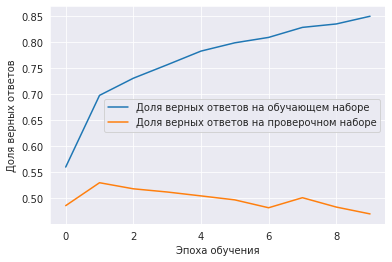

In [ ]:
maxWordsCount = 100

xTrain, xTest, yTrain, yTest, Test, x2 = takeData(maxWordsCount)
model = createModel()
history = model.fit(xTrain, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))
recognizeMultiClass(model, Test, "maxWordsCount=100")


showTable(history)

### Эксперимент 2 (maxWordsCount=1000)


Время обработки: 3.19c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.53c
Время обработки: 8.12c
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 200)               200200    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 200)               800       
_________________________________________________________________
dense_33 (Dense)             (None, 6)                 1206      
Total params: 202,206
Trainable params: 201,806
Non-trainable params: 400
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 2s 9ms/step - loss: 0.2146 - accuracy: 0.9358 - val_loss: 0.5302 - val_accuracy: 0.8264
Epoch 2/10
138/138 [==============================] - 1

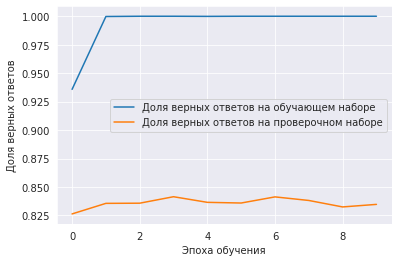

In [ ]:
maxWordsCount = 1000

xTrain, xTest, yTrain, yTest, Test, x2 = takeData(maxWordsCount)
model = createModel()
history = model.fit(xTrain, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))
recognizeMultiClass(model, Test, "maxWordsCount=1000")

showTable(history)

### Эксперимент 3 (maxWordsCount=10000)

Время обработки: 3.17c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.85c
Время обработки: 13.11c
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 200)               800       
_________________________________________________________________
dense_35 (Dense)             (None, 6)                 1206      
Total params: 2,002,206
Trainable params: 2,001,806
Non-trainable params: 400
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 6s 40ms/step - loss: 0.0596 - accuracy: 0.9819 - val_loss: 0.3994 - val_accuracy: 0.8827
Epoch 2/10
138/138 [=============================

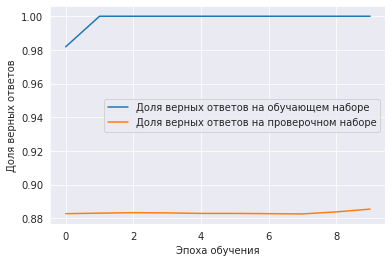

In [ ]:
maxWordsCount = 10000

xTrain, xTest, yTrain, yTest, Test, x2 = takeData(maxWordsCount)
model = createModel()
history = model.fit(xTrain, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))
recognizeMultiClass(model, Test, "maxWordsCount=10000")

showTable(history)

### Эксперимент 4 (maxWordsCount=50000)

#### не хватает памяти

In [ ]:
# maxWordsCount = 50000

# xTrain, xTest, yTrain, yTest, Test, x2 = takeData(maxWordsCount)
# model = createModel()
# history = model.fit(xTrain, 
#                       yTrain, 
#                       epochs=10,
#                       batch_size=128,
#                       validation_data=(xTest, yTest))

# accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))
# accuracyTest.append(recognizeMultiClass(model, Test, "maxWordsCount=50000"))

# showTable(history)

## Эксперимент с обучением модели (Часть Б)

### Эксперимент 5 (maxWordsCount=10000 || другое количество нейронов в сети)



Время обработки: 3.13c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.52c
Время обработки: 12.77c
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 400)               4000400   
_________________________________________________________________
dropout_17 (Dropout)         (None, 400)               0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 400)               1600      
_________________________________________________________________
dense_37 (Dense)             (None, 6)                 2406      
Total params: 4,004,406
Trainable params: 4,003,606
Non-trainable params: 800
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 10s 67ms/step - loss: 0.0437 - accuracy: 0.9857 - val_loss: 0.4314 - val_accuracy: 0.8537
Epoch 2/10
138/138 [============================

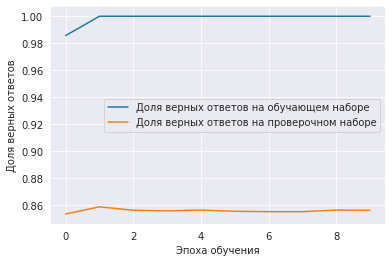

In [ ]:
nNeurons = 400
xTrain, xTest, yTrain, yTest, Test, x2 = takeData()
model = createModel(neuronsOneLayers=nNeurons)
history = model.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))
recognizeMultiClass(model, Test, "Another set of neurons")

showTable(history)

### Эксперимент 6 (maxWordsCount=10000 || другое количество слоев)



Время обработки: 3.27c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.56c
Время обработки: 11.83c
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dense_39 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_40 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 200)               800       
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 1206      
Total params: 2,082,606
Trainable params: 2,082,206
Non-trainable params

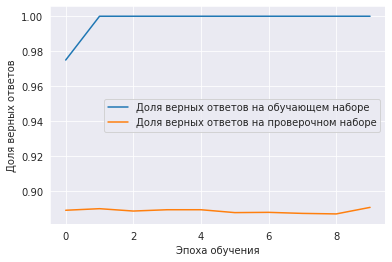

In [ ]:
layersN = 3

xTrain, xTest, yTrain, yTest, Test, x2 = takeData()
model = createModel(layersN=layersN)
history = model.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))
recognizeMultiClass(model, Test, "Another number of layers")

showTable(history)

### Эксперимент 7 (maxWordsCount=10000 || другие активационные функции)


Время обработки: 3.2c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.5c
Время обработки: 11.73c
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 200)               800       
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 1206      
Total params: 2,002,206
Trainable params: 2,001,806
Non-trainable params: 400
_________________________________________________________________
Epoch 1/10
138/138 [==============================] - 6s 39ms/step - loss: 0.0459 - accuracy: 0.9853 - val_loss: 0.3770 - val_accuracy: 0.8786
Epoch 2/10
138/138 [==============================

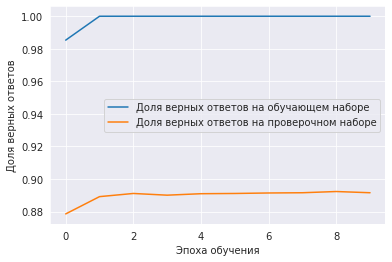

In [ ]:
activ = "linear"
xTrain, xTest, yTrain, yTest, Test, x2 = takeData()
model = createModel(activ=activ)
history = model.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))
recognizeMultiClass(model, Test, "Another activation function")

showTable(history)

## Эксперименты с обучение модели (Часть В)

### Эксперимент 8 (maxWordsCount=10000||embedding=10)

Время обработки: 3.23c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.83c
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 10)          100000    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 1000, 10)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 10000)             40000     
_________________________________________________________________
dense_44 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_29 (Batc (

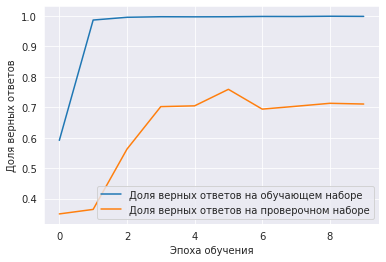

In [ ]:
xTrain, yTrain, xTest, yTest = takeData(level=True)

model = createModelEmbed(embedding=10)

history = model.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))

showTable(history)

### Эксперимент 9 (maxWordsCount=10000||embedding=50)

Время обработки: 3.34c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 2.61c
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 1000, 50)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 50000)             0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 50000)             200000    
_________________________________________________________________
dense_46 (Dense)             (None, 64)                3200064   
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_31 (Batc (

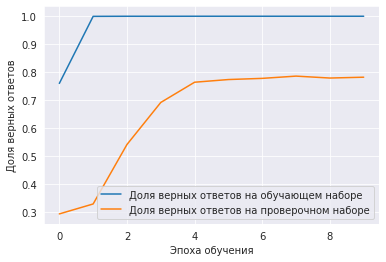

In [ ]:
xTrain, yTrain, xTest, yTest = takeData(level=True)

model = createModelEmbed(embedding=50)
history = model.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))
showTable(history)

### Эксперимент 10 (maxWordsCount=10000||embedding=200)

Время обработки: 3.39c


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Время обработки: 3.01c
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 200)         2000000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 1000, 200)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 200000)            0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 200000)            800000    
_________________________________________________________________
dense_48 (Dense)             (None, 64)                12800064  
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_33 (Batc (

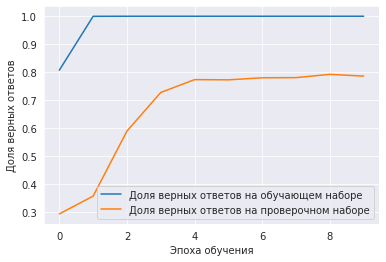

In [ ]:
xTrain, yTrain, xTest, yTest = takeData(level=True)
model = createModelEmbed(embedding=200)
history = model.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

accuracyTotal.append(model.evaluate(xTest, yTest, verbose=1))


showTable(history)

# Таблица точностей моделей

In [ ]:
names = ["maxWordsCount=100", "maxWordsCount=1000",
         "maxWordsCount=10000", "maxWordsCount=50000",
         "another set of neurons", "another count of layers", 
         "another activation function", "embedding=10", 
         "embedding=50", "embedding=200"]

accuracy = [elem[1] for elem in accuracyTotal]
accuracy.append(True)

for ii in range(4, len(accuracyTotal) + 1):
  accuracy[ii] = accuracyTotal[ii - 1][1]
accuracy[3] = "Не хватило памяти"

accuracyTable = pd.DataFrame({"Название эксперимента:": names,
                              "Точность на проверочной выборке:": accuracy},
                             index=[i for i in range(1, len(names) + 1)])
print(accuracyTable)

         Название эксперимента: Точность на проверочной выборке:
1             maxWordsCount=100                         0.469937
2            maxWordsCount=1000                         0.834729
3           maxWordsCount=10000                         0.885432
4           maxWordsCount=50000                Не хватило памяти
5        another set of neurons                         0.856416
6       another count of layers                         0.890667
7   another activation function                         0.891564
8                  embedding=10                         0.710888
9                  embedding=50                         0.781932
10                embedding=200                         0.785821
